<a href="https://colab.research.google.com/github/Untick/NetOptik/blob/main/Lytkin%20Vladimir/Netoptic_material_ae_bot_and_YOLO8_VL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание НС для определения материала оправы очков (металл или пластик)

### Загрузка библиотек


In [ ]:
# Работа с массивами
import numpy as np

# Генератор аугментированных изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Основа для создания последовательной модели
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# Оптимизатор
from tensorflow.keras.optimizers import Adam

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Подключение модуля для загрузки данных из облака
import gdown

# Инструменты для работы с файлами
import os

# Генерация случайных чисел
import random

#Библиотеки для отрисовки
from PIL import Image
import matplotlib.pyplot as plt

# Рисование графиков в ячейках Colab
%matplotlib inline

### Задание гиперпараметров модели

In [ ]:
# Задание гиперпараметров

TRAIN_PATH          = '/content/frames/'       # Папка для обучающего набора данных
TEST_PATH           = '/content/frames_test/'  # Папка для тестового набора данных

TEST_SPLIT          = 0.1                     # Доля тестовых данных в общем наборе
VAL_SPLIT           = 0.2                    # Доля проверочной выборки в обучающем наборе

IMG_WIDTH           = 256                   # Ширина изображения для нейросети
IMG_HEIGHT          = 512                    # Высота изображения для нейросети
IMG_CHANNELS        = 3                     # Количество каналов (для RGB равно 3, для Grey равно 1)

# Параметры аугментации
ROTATION_RANGE      = 8                     # Пределы поворота
WIDTH_SHIFT_RANGE   = 0.15                  # Пределы сдвига по горизонтали (float: fraction of total width, if < 1, or pixels if >= 1)
HEIGHT_SHIFT_RANGE  = 0.15                  # Пределы сдвига по вертикали   (float: fraction of total height, if < 1, or pixels if >= 1
ZOOM_RANGE          = 0.15                  # Пределы увеличения/уменьшения
# BRIGHTNESS_RANGE    = (0.7, 1.3)            # Пределы изменения яркости
HORIZONTAL_FLIP     = True                  # Горизонтальное отражение разрешено

EPOCHS              = 30                    # Число эпох обучения
BATCH_SIZE          = 50                    # Размер батча для обучения модели (значительно влияет на обучение, 40 лучше 25)
OPTIMIZER           = Adam(0.0001)         # Оптимизатор

FILE_BEST_WEIGHTS        = '/content/drive/MyDrive/data_stazhirovka1/material_best_model_w.h5'    # веса модели с лучщим val_accuracy
FILE_LAST_WEIGHTS        = '/content/drive/MyDrive/data_stazhirovka1/material_last_model_w.h5'    # веса модели после окончания обучения на всех эпохах

### Загрузка датасета с Google диска

In [ ]:
# Монтирование GoogleDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Загрузка zip-архива с GoogleDrive на диск виртуальной машины Colab
gdown.download('https://drive.google.com/uc?id=1JyMoZOJBwTY2MI9oFFHt4Brf3Q_ULWk5', None, quiet=True)

'glass_material_no_combi.zip'

In [ ]:
# Разархивация датасета в директорию 'content/frames'
# !unzip -qo "glass_material.zip" -d /content/frames
!unzip -qo "glass_material_no_combi.zip" -d /content/frames

In [ ]:
# Проверка загрузки
os.listdir(TRAIN_PATH)

['Металл 418', 'Пластик 500']

### Подготовка данных

In [ ]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(TRAIN_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['Металл 418', 'Пластик 500']


In [ ]:
# списки файлов для всех классов (проверка)
# for cls in CLASS_LIST:
#     print(cls, ':', os.listdir(f'{IMAGE_PATH}{cls}/'))

In [ ]:
# Перенос файлов для теста в отдельное дерево папок, расчет размеров наборов данных

try:
  os.mkdir(TEST_PATH)                                        # Создание папки для тестовых данных
except:
  pass

train_count = 0
test_count = 0

for class_name in CLASS_LIST:                              # Для всех классов по порядку номеров (их меток)
    class_path = f'{TRAIN_PATH}{class_name}'              # Формирование полного пути к папке с изображениями класса
    test_path = f'{TEST_PATH}{class_name}'                # Полный путь для тестовых данных класса
    class_files = os.listdir(class_path)                   # Получение списка имен файлов с изображениями текущего класса
    class_file_count = len(class_files)                    # Получение общего числа файлов класса

    try:
      os.mkdir(test_path)                                    # Создание подпапки класса для тестовых данных
    except:
      pass

    test_file_count = int(class_file_count * TEST_SPLIT)   # Определение числа тестовых файлов для класса
    test_files = class_files[-test_file_count:]            # Выделение файлов для теста от конца списка
    for f in test_files:                                   # Перемещение тестовых файлов в папку для теста
        os.rename(f'{class_path}/{f}', f'{test_path}/{f}')
    train_count += class_file_count                        # Увеличение общего счетчика файлов обучающего набора
    test_count += test_file_count                          # Увеличение общего счетчика файлов тестового набора

    print(f'Размер класса {class_name}: {class_file_count} оправ, для теста выделено файлов: {test_file_count}')

print(f'Общий размер базы: {train_count}, выделено для обучения: {train_count - test_count}, для теста: {test_count}')

Размер класса Металл 418: 418 оправ, для теста выделено файлов: 41
Размер класса Пластик 500: 499 оправ, для теста выделено файлов: 49
Общий размер базы: 917, выделено для обучения: 827, для теста: 90


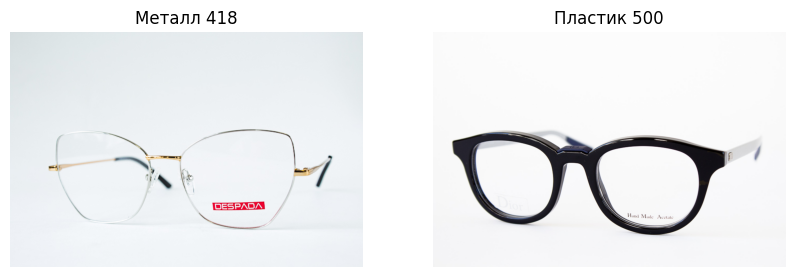

In [ ]:
# Отрисовка по одному изображению, выбранному случайно, из каждого класса обучающей выборки
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(10, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):
    # Формирование пути к папке содержимого класса
    frame_path = f'{TRAIN_PATH}{CLASS_LIST[i]}/'
    # Выбор случайного фото из i-го класса
    img_path = frame_path + random.choice(os.listdir(frame_path))
    # Отображение фотографии
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

### Генераторы изображений и выборок

In [ ]:
# Генераторы изображений

# Изображения для обучающего набора нормализуются и аугментируются согласно заданным гиперпараметрам
# Далее набор будет разделен на обучающую и проверочную выборку в соотношении VAL_SPLIT
train_datagen = ImageDataGenerator(
                    rescale=1. / 255.,                      # Перескалирование значений пикселей изображений, чтобы они находились в диапазоне от 0 до 1
                    rotation_range=ROTATION_RANGE,          # случайные повороты в диапазоне [-RORATION_RANGE, ROTAION_RANGE] градусов
                    width_shift_range=WIDTH_SHIFT_RANGE,    # случайное горизонтальное смещение в диапазоне [-WIDTH_SHIFT_RANGE, WIDTH_SHIFT_RANGE] пикселей
                    height_shift_range=HEIGHT_SHIFT_RANGE,  # случайное вертикальное смещение в диапазоне [-HEIGHT_SHIFT_RANGE, HEIGHT_SHIFT_RANGE] пикселей
                    zoom_range=ZOOM_RANGE,                  # случайное масштабирование в диапазоне ZOOM_RANGE в процентах (0.2=20%)
                    horizontal_flip=HORIZONTAL_FLIP,        # Случайное отражение изображений по горизонтали (True or False)
                    validation_split=VAL_SPLIT              # доля проверочной выборке от общего количества тренировочной выборки
                )

# Изображения для тестового набора только нормализуются
test_datagen = ImageDataGenerator(
                   rescale=1. / 255.
                )

In [ ]:
# Обучающая выборка генерируется из папки обучающего набора
train_generator = train_datagen.flow_from_directory(
    # Путь к обучающим изображениям
    TRAIN_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

# Проверочная выборка также генерируется из папки обучающего набора
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

# Тестовая выборка генерируется из папки тестового набора
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=test_count,
    class_mode='categorical',
    shuffle=True,
)

Found 662 images belonging to 2 classes.
Found 165 images belonging to 2 classes.
Found 90 images belonging to 2 classes.


In [ ]:
# Проверка формы данных
print(f'Формы данных тренировочной выборки: {train_generator[0][0].shape}, {train_generator[0][1].shape}, батчей: {len(train_generator)}')
print(f'Формы данных   проверочной выборки: {validation_generator[0][0].shape}, {validation_generator[0][1].shape}, батчей: {len(validation_generator)}')
print(f'Формы данных      тестовой выборки: {test_generator[0][0].shape}, {test_generator[0][1].shape}, батчей: {len(test_generator)}')

print()

# Проверка назначения меток классов
print(f'Метки классов тренировочной выборки: {train_generator.class_indices}')
print(f'Метки классов   проверочной выборки: {validation_generator.class_indices}')
print(f'Метки классов      тестовой выборки: {test_generator.class_indices}')

Формы данных тренировочной выборки: (50, 256, 512, 3), (50, 2), батчей: 14
Формы данных   проверочной выборки: (50, 256, 512, 3), (50, 2), батчей: 4
Формы данных      тестовой выборки: (90, 256, 512, 3), (90, 2), батчей: 1

Метки классов тренировочной выборки: {'Металл 418': 0, 'Пластик 500': 1}
Метки классов   проверочной выборки: {'Металл 418': 0, 'Пластик 500': 1}
Метки классов      тестовой выборки: {'Металл 418': 0, 'Пластик 500': 1}


In [ ]:
# Функция рисования образцов изображений из заданной выборки

def show_batch(batch,                # батч с примерами
               img_range=range(25),  # диапазон номеров картинок
               figsize=(12, 4),      # размер полотна для рисования одной строки таблицы
               columns=5             # число колонок в таблице
               ):

    for i in img_range:
        ix = i % columns
        if ix == 0:
            fig, ax = plt.subplots(1, columns, figsize=figsize)
        class_label = np.argmax(batch[1][i])
        ax[ix].set_title(CLASS_LIST[class_label])
        ax[ix].imshow(batch[0][i])
        ax[ix].axis('off')
        plt.tight_layout()

    plt.show()

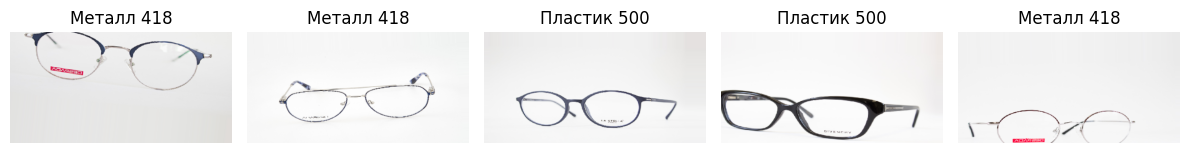

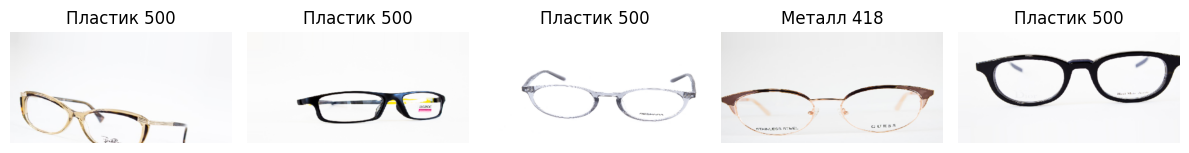

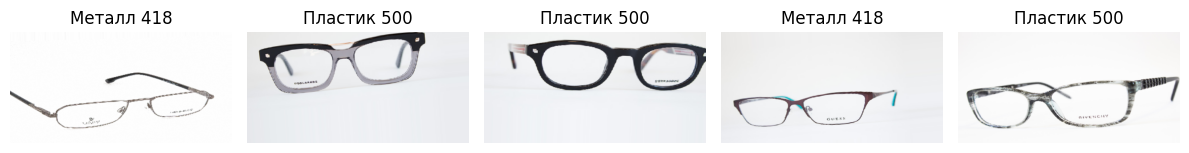

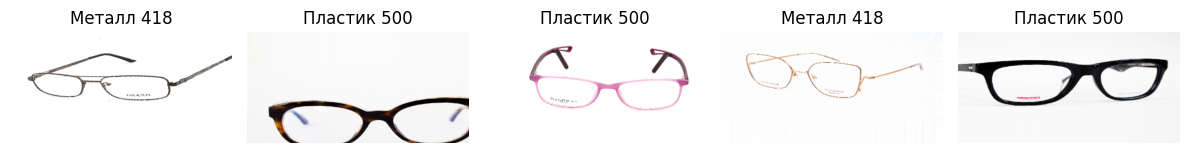

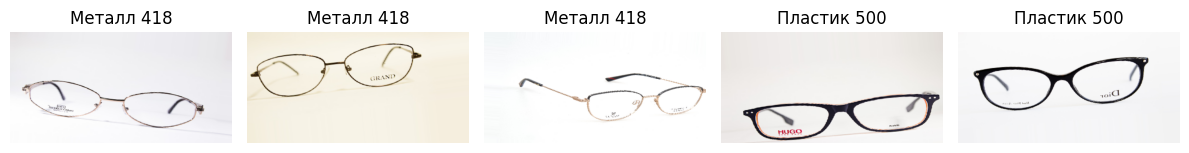

In [ ]:
# Вывод примеров из 0-го батча train_generator
show_batch(train_generator[0])

### Создание нейронной сети на основе предобученной VGG16

In [ ]:
# Библиотеки предобученной сети VGG16
from keras.applications import VGG16

# Загружаем предварительно обученную нейронную сеть
model_vgg16_trained = VGG16(weights='imagenet',                         # признаки из набора данных "ImageNet"
                            include_top=False,                          # отключаем часть "классификация", оставляем только "сверточную часть"
                            input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))     # размер тензора входных изображений

# "Замораживаем" веса предварительно обученной нейронной сети VGG16 (сверточную часть обучать не будем)
model_vgg16_trained.trainable = False
model_vgg16_trained.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 256, 128)     147584    
                                                              

In [ ]:
# Создаем свою составную сеть на основе предобученной VGG16

model = Sequential()
# Добавляем в модель сеть VGG16 вместо слоя
model.add(model_vgg16_trained)
# Блок классификации
model.add(Flatten(name='Class_1'))
model.add(Dense(256, activation='relu', name='Class_2'))
model.add(Dropout(0.3))
model.add(Dense(CLASS_COUNT, activation='softmax', name='Class_3'))


In [ ]:
# Архитектура созданной сети
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 8, 512)         14714688  
                                                                 
 Class_1 (Flatten)           (None, 16384)             0         
                                                                 
 Class_2 (Dense)             (None, 256)               4194560   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 Class_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 18,909,762
Trainable params: 4,195,074
Non-trainable params: 14,714,688
_________________________________________________________________


### Компиляция и обучение модели с сохранением лучших весов в файле FILE_BEST_WEIGHTS

In [ ]:
# Функция компиляции и обучения модели нейронной сети с сохранением лучших весов на GoogleDrive
# По окончанию выводит графики обучения
from tensorflow.keras.callbacks import ModelCheckpoint

def compile_train_model(model,                  # модель нейронной сети
                        train_data,             # обучающие данные
                        val_data,               # проверочные данные
                        optimizer=OPTIMIZER,    # оптимизатор
                        epochs=EPOCHS,          # количество эпох обучения
                        batch_size=BATCH_SIZE,  # размер батча
                        figsize=(20, 5)):       # размер полотна для графиков

    # Компиляция модели
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])

    # Обучение модели с заданными параметрами
    checkpoint_callback = ModelCheckpoint(filepath=FILE_BEST_WEIGHTS,
                                          save_weights_only=True,
                                          monitor='val_accuracy',
                                          save_best_only=True)
    history = model.fit(train_data,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=val_data,
                        callbacks=checkpoint_callback)                # лучший результат

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

Epoch 1/30
14/14 [==============================] - 77s 4s/step - loss: 1.0545 - accuracy: 0.5770 - val_loss: 0.4835 - val_accuracy: 0.7576
Epoch 2/30
14/14 [==============================] - 44s 3s/step - loss: 0.3153 - accuracy: 0.8640 - val_loss: 0.2336 - val_accuracy: 0.9394
Epoch 3/30
14/14 [==============================] - 43s 3s/step - loss: 0.1521 - accuracy: 0.9547 - val_loss: 0.1904 - val_accuracy: 0.9515
Epoch 4/30
14/14 [==============================] - 42s 3s/step - loss: 0.1103 - accuracy: 0.9773 - val_loss: 0.2240 - val_accuracy: 0.8909
Epoch 5/30
14/14 [==============================] - 42s 3s/step - loss: 0.1050 - accuracy: 0.9683 - val_loss: 0.2371 - val_accuracy: 0.8970
Epoch 6/30
14/14 [==============================] - 42s 3s/step - loss: 0.0737 - accuracy: 0.9789 - val_loss: 0.1955 - val_accuracy: 0.9091
Epoch 7/30
14/14 [==============================] - 43s 3s/step - loss: 0.0893 - accuracy: 0.9668 - val_loss: 0.1934 - val_accuracy: 0.9091
Epoch 8/30
14/14 [==

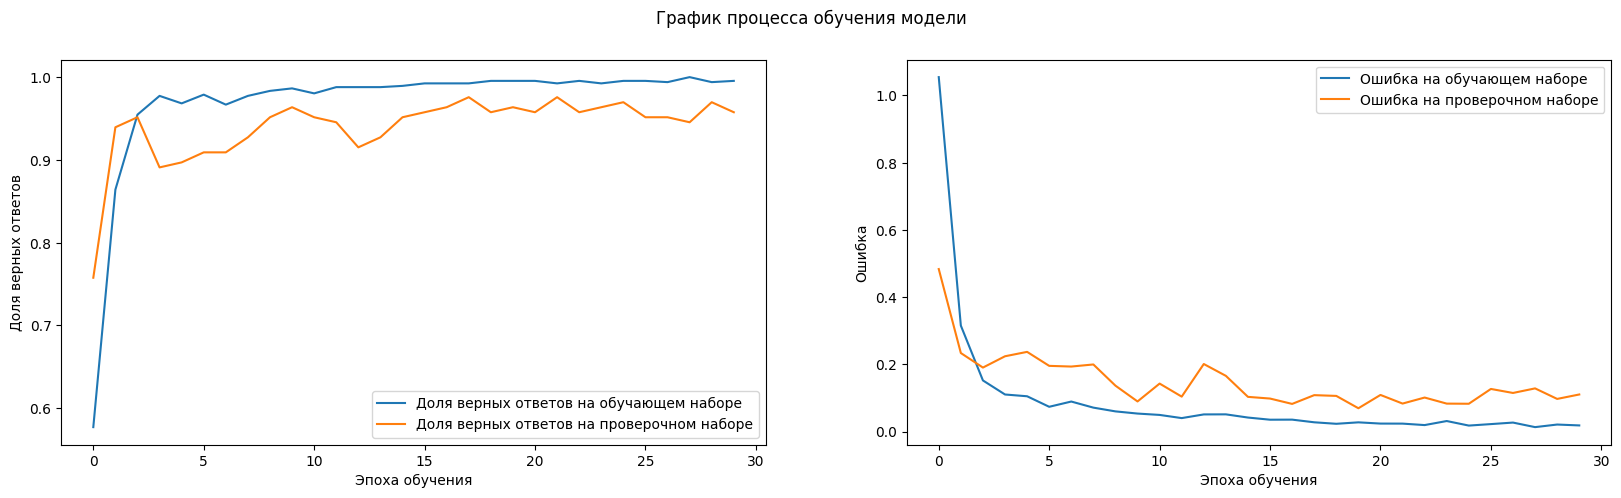

In [ ]:
# Компиляция и обучение модели на заданных параметрах
compile_train_model(model,
                    train_generator,
                    validation_generator)

In [ ]:
# Сохранение весов после окончания всех эпох в файл
model.save_weights(FILE_LAST_WEIGHTS)

### Загрузка сохраненных лучших или последних весов из каталога GoogleDrive

In [ ]:
# Загрузка сохраненных лучших весов из GoogleDrive
model.load_weights(FILE_BEST_WEIGHTS)

In [ ]:
# Загрузка сохраненных последних весов из GoogleDrive
model.load_weights(FILE_LAST_WEIGHTS)

### Проверка на тестовом наборе: отрисовка матрицы ошибок

In [ ]:
# Функция вывода результатов оценки модели на заданных данных

def eval_model(model,
               x,                # данные для предсказания модели (вход)
               y_true,           # верные метки классов в формате OHE (выход)
               class_labels=[],  # список меток классов
               cm_round=3,       # число знаков после запятой для матрицы ошибок
               title='',         # название модели
               figsize=(10, 10)  # размер полотна для матрицы ошибок
               ):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    ax.images[-1].colorbar.remove()       # Стирание ненужной цветовой шкалы
    fig.autofmt_xdate(rotation=45)        # Наклон меток горизонтальной оси
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))



3/3 [==============================] - 1s 327ms/step


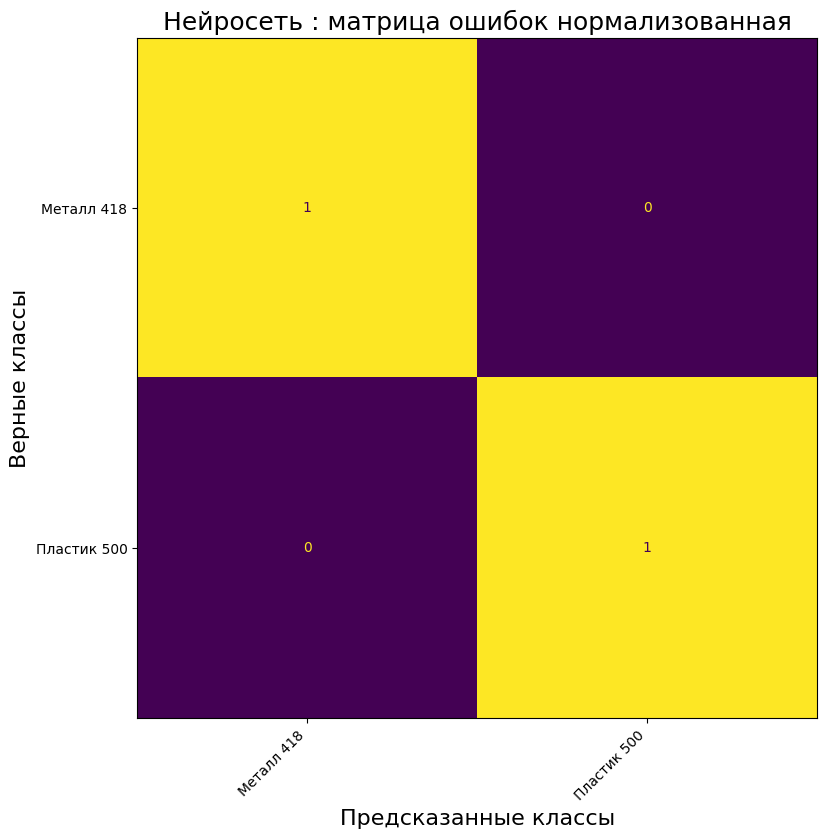

----------------------------------------------------------------------------------------------------
Нейросеть: 
Класс: Металл 418           100% сеть отнесла к классу Металл 418           - ВЕРНО :-)
Класс: Пластик 500          100% сеть отнесла к классу Пластик 500          - ВЕРНО :-)

Средняя точность распознавания: 100%


In [ ]:
# Отрисовка матрицы ошибок
eval_model(model, test_generator[0][0], test_generator[0][1], class_labels=CLASS_LIST)

# Автокодировщик для распознавания очков на изображении

### Загрузка библиотек

In [ ]:
# Работа с операционной системой
import os

# Работа с массивами данных
import numpy as np

# Работа с таблицами
import pandas as pd

# Основные слои
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization

# класс для использования Functional API
from tensorflow.keras import Model

# Оптимизаторы для обучения модели
from tensorflow.keras.optimizers import Adam

# Функции-утилиты
from tensorflow.keras import utils

# Готовые датасеты
from tensorflow.keras.datasets import mnist, fashion_mnist

# Коллбэки для выдачи информации в процессе обучения
from tensorflow.keras.callbacks import LambdaCallback

# Отрисовка изображения
from tensorflow.keras.preprocessing import image

# Разбиение на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split

# Функция среднеквадратической ошибки для расчетов вручную
from sklearn.metrics import mean_squared_error

# Отрисовка графиков
import matplotlib.pyplot as plt

# Для работы сизображениями
from PIL import Image

%matplotlib inline

### Параметры

In [ ]:
# ОБУЧЕНИЕ НА 64х128
IMG_WIDTH = 64
IMG_HEIGHT = 128
TEST_SPLIT          = 0.1                     # Доля тестовых данных в общем наборе
VAL_SPLIT           = 0.2                    # Доля проверочной выборки в обучающем наборе
FILE_BEST_MODEL = '/content/drive/MyDrive/data_stazhirovka1/autocoder_best_model_v64x128.h5'    # модель с лучщим val_loss
FILE_LAST_MODEL = '/content/drive/MyDrive/data_stazhirovka1/autocoder_last_model_v64x128.h5'    # модель после окончания всего обучения

### Загрузка файлов изображений и подготовка датасета

In [ ]:
# Загрузка датасета

# монтование GoogleDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Загрузка zip-архива с GoogleDrive на диск виртуальной машины colab
import gdown
# gdown.download('https://drive.google.com/uc?id=1FNq2k93jLoXEp7eQslg94Rd2bdWI09cj', None, quiet=True)
gdown.download('https://drive.google.com/uc?id=1JyMoZOJBwTY2MI9oFFHt4Brf3Q_ULWk5', None, quiet=True)

'glass_material_no_combi.zip'

In [ ]:
# Разархивация датасета в директорию 'content/frames'
# !unzip -qo "glass_material.zip" -d /content/frames
!unzip -qo "glass_material_no_combi.zip" -d /content/frames

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '/content/frames/'

In [ ]:
# Проверка загрузки
import os
os.listdir(IMAGE_PATH)

['Пластик 500', 'Металл 418']

In [ ]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['Металл 418', 'Пластик 500']


In [ ]:
# Создание списков файлов и их меток класса

data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} оправ')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print('Общий размер базы для обучения:', len(data_labels))

Размер класса Металл 418 составляет 418 оправ
Размер класса Пластик 500 составляет 499 оправ
Общий размер базы для обучения: 917


In [ ]:
# Формирование набора данных
# Задание единых размеров изображений

data_images = []                          # Пустой список для данных изображений

for file_name in data_files:
    img = Image.open(file_name).resize((IMG_HEIGHT, IMG_WIDTH)).convert('L')   # Открытие и смена размера изображения и преобразование из цветного (3 канала) в серый (1 канал)
    img_np = np.array(img)                                        # Перевод в numpy-массив
    data_images.append(img_np)                                    # Добавление изображения в виде numpy-массива к общему списку

x_data = np.array(data_images)                                    # Перевод общего списка изображений в numpy-массив
y_data = np.array(data_labels)                                    # Перевод общего списка меток класса в numpy-массив

print(f'В массив собрано {len(data_images)} фотографий следующей формы: {img_np.shape}')
print(f'Общий массив данных изображений следующей формы: {x_data.shape}')
print(f'Общий массив меток классов следующей формы: {y_data.shape}')

В массив собрано 917 фотографий следующей формы: (64, 128)
Общий массив данных изображений следующей формы: (917, 64, 128)
Общий массив меток классов следующей формы: (917,)


In [ ]:
# Приведение всех картинок к нужной форме
x_data_ = x_data.reshape(-1, x_data.shape[1], x_data.shape[2], 1)

In [ ]:
# Приведение всех картинок к нужному типу и нормализация пикселей в диапазон [0,1]
x_data = x_data_.astype('float32') / 255.

In [ ]:
# Разбиение на обучающие и проверочные целевые изображения
x_train, x_test = train_test_split(x_data, test_size=TEST_SPLIT)

# Размерность выборки
print(x_train.shape, x_test.shape, sep='\n')

(825, 64, 128, 1)
(92, 64, 128, 1)


In [ ]:
# Проверка формы данных
print(x_data.shape)

(917, 64, 128, 1)


###  Функция сборки автокодировщика

In [ ]:
# Функция сборки сверточного автокодировщика
def create_base_ae(in_shape):
    # Энкодер, вход нейросети
    img_input = Input(in_shape)

    # Энкодер, первый блок
    # 1.1. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input)
    # 1.2. Нормализация
    x = BatchNormalization()(x)
    # 1.3. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    # 1.4. Нормализация
    x = BatchNormalization()(x)
    # 1.5. Снижение размерности и обобщение данных
    x = MaxPooling2D()(x)

    # Энкодер, второй блок
    # 2.1. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 2.2. Нормализация
    x = BatchNormalization()(x)
    # 2.3. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 2.4. Нормализация
    x = BatchNormalization()(x)


    # На выходе кодировщика и на входе декодировщика z - вектор латентного пространства
    # 2.5. Снижение размерности и обобщение данных
    z = MaxPooling2D()(x)


    # Декодер, первый блок
    # 1.1. Транспонированная свертка - повышение размерности данных
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z)
    # 1.2. Нормализация
    x = BatchNormalization()(x)
    # 1.3. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 1.4. Нормализация
    x = BatchNormalization()(x)
    # 1.5. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 1.6. Нормализация
    x = BatchNormalization()(x)

    # Декодер, второй блок
    # 2.1. Транспонированная свертка - повышение размерности данных
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x)
    # 2.2. Нормализация
    x = BatchNormalization()(x) # слой нормализации данных
    # 2.3. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    # 2.4. Нормализация
    x = BatchNormalization()(x) # слой нормализации данных
    # 2.5. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    # 2.6. Нормализация
    x = BatchNormalization()(x)

    # Декодер, финальный слой двумерной свертки, выдающий итоговое изображение
    outputs = Conv2D(in_shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    # Сборка модели, на входе оригинальное изображение, на выходе - сжатое-восстановленное
    model = Model(inputs=img_input, outputs=outputs)

    # Компиляция сети, назначение оптимизатора Adam + среднеквадратическая ошибка
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

    # Возврат готовой модели
    return model

### Сервисные функции

In [ ]:
# Функция последовательного вывода нескольких изображений для сравнения
# x_data – оригинальные изображения;
# pred – изображения после автокодировщика;
# n – количество изображений каждого типа.

def plot_images(x_data, pred, n=5):

    plt.figure(figsize=(14, 7))                     # Размер полотна

    for i in range(1, n + 1):                              # Повтор n раз:
        index = np.random.randint(0, pred.shape[0]) # Выбор случайного индекса

        # Показ картинки с индексом index из набора x_data
        ax = plt.subplot(2, n, i)               # Картинка располагается в верхнем ряду
        plt.imshow(x_data[index].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Показ картинки с тем же индексом из предсказания автокодировщика
        ax = plt.subplot(2, n, i + n)           # Картинка располагается в нижнем ряду
        plt.imshow(pred[index].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

### Обучение автокодировщика на датасете очков

In [ ]:
# Сборка автокодировщика для формы картинок датасета
ae_glasses = create_base_ae(x_train.shape[1:])

In [ ]:
# Сводка архитектуры автокодировщика
ae_glasses.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 64, 128, 32)       320       
                                                                 
 batch_normalization (Batch  (None, 64, 128, 32)       128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 128, 32)       9248      
                                                                 
 batch_normalization_1 (Bat  (None, 64, 128, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 64, 32)        0     

In [ ]:
# Визуальная схема архитектуры модели
utils.plot_model(ae_glasses,
                 dpi=70,                  # число точек на дюйм (дюйм = 2.54 см)
                 show_shapes=True         # отображение ожидаемых форм входных и выходных тензоров каждого слоя
                 )

In [ ]:
# callback для сохранения лучшей модели
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(filepath=FILE_BEST_MODEL,
                                          save_weights_only=False,
                                          monitor='val_loss',
                                          save_best_only=True)

In [ ]:
# Обучение модели автокодировщика, на входе и выходе одни и те же данные
history = ae_glasses.fit(x_train, x_train,
                        epochs=150,
                        batch_size=50,
                        validation_split=VAL_SPLIT,
                        callbacks=checkpoint_callback)

Epoch 1/150
14/14 [==============================] - 20s 215ms/step - loss: 0.2255 - val_loss: 0.1996
Epoch 2/150


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 95ms/step - loss: 0.1790 - val_loss: 0.1768
Epoch 3/150
14/14 [==============================] - 1s 99ms/step - loss: 0.1446 - val_loss: 0.1469
Epoch 4/150
14/14 [==============================] - 1s 101ms/step - loss: 0.1185 - val_loss: 0.1187
Epoch 5/150
14/14 [==============================] - 1s 93ms/step - loss: 0.1006 - val_loss: 0.0963
Epoch 6/150
14/14 [==============================] - 1s 92ms/step - loss: 0.0879 - val_loss: 0.0795
Epoch 7/150
14/14 [==============================] - 1s 97ms/step - loss: 0.0782 - val_loss: 0.0676
Epoch 8/150
14/14 [==============================] - 1s 93ms/step - loss: 0.0709 - val_loss: 0.0586
Epoch 9/150
14/14 [==============================] - 1s 90ms/step - loss: 0.0650 - val_loss: 0.0515
Epoch 10/150
14/14 [==============================] - 1s 91ms/step - loss: 0.0597 - val_loss: 0.0464
Epoch 11/150
14/14 [==============================] - 1s 96ms/step - loss: 0.0552 - val_loss: 0.0419
Epoch 12/

In [ ]:
# FILE_LAST_MODEL        = '/content/drive/MyDrive/data_stazhirovka1/autocoder_last_model_v64x128.h5'
# Сохранение модели после окончания всех эпох в файл
ae_glasses.save(FILE_LAST_MODEL)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


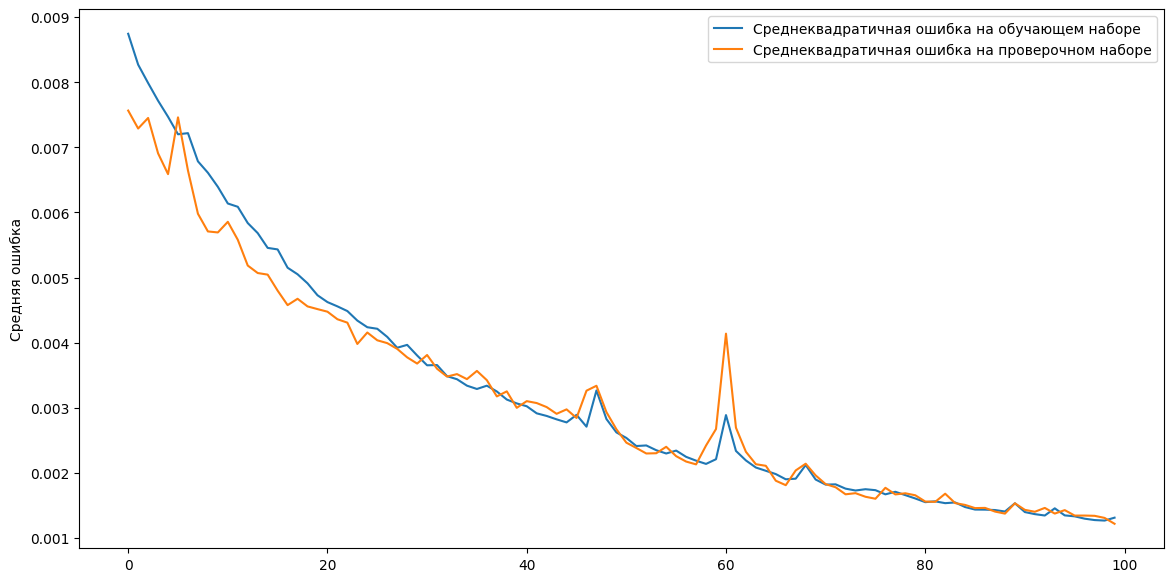

In [ ]:
# Вывод графиков процесса обучения
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'][50:],
         label='Среднеквадратичная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][50:],
         label='Среднеквадратичная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
# восстановление всей модели
# Загрузка сохраненной модели
from tensorflow.keras.models import load_model
ae_glasses = load_model(FILE_BEST_MODEL) # Загружаем модель

In [ ]:
# Получение предсказания автокодировщика на тренировочной и тестовой выборках
pred_train_glasses = ae_glasses.predict(x_train)
pred_test_glasses = ae_glasses.predict(x_test)

3/3 [==============================] - 0s 189ms/step


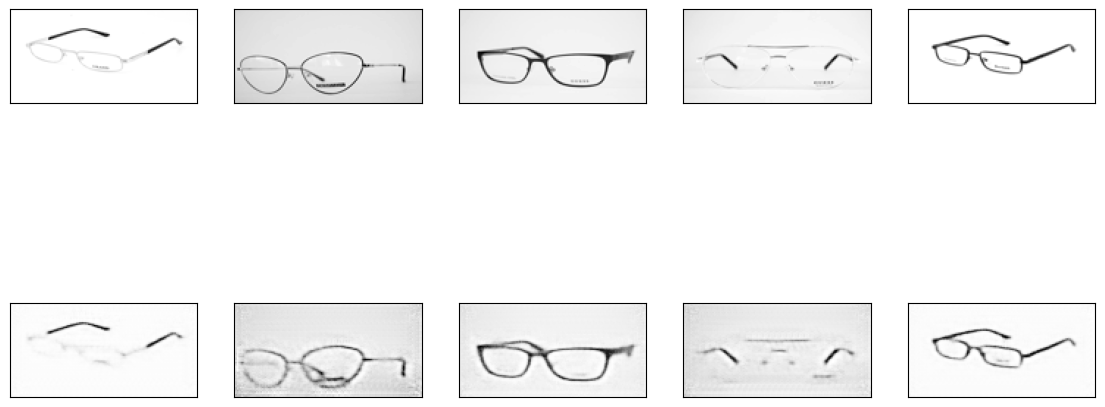

In [ ]:
# Сравнение исходных и восстановленных картинок из обучающей выборки
plot_images(x_test, pred_test_glasses)

### Вычисление ошибки на тренировочном и тестовом наборе

In [ ]:
# Расчет количества пикселей изображения
image_size = x_train.shape[1] * x_train.shape[2]

# Расчет массивов среднеквадратических ошибок по всем картинкам тренировочной и тестовой выборок.
# mean_squared_error() ожидает двумерный вектор, для чего каждую картинку придется
# "сплющить" до одномерного вектора размера image_size
err_train = mean_squared_error(x_train.reshape(-1, image_size).T,
                                     pred_train_glasses.reshape(-1, image_size).T,
                                     multioutput='raw_values')
err_test  = mean_squared_error(x_test.reshape(-1, image_size).T,
                                     pred_test_glasses.reshape(-1, image_size).T,
                                     multioutput='raw_values')

# Вывод средних ошибок
print('Средняя ошибка на обучающем наборе очков: {:.5f}'.format(err_train.mean()))
print('Средняя ошибка на  тестовом наборе очков: {:.5f}'.format(err_test.mean()))
print('Максимальная ошибка на обучающем наборе очков:  {:.5f}'.format(err_train.max()))
print('Максимальная ошибка на  тестовом наборе очков:   {:.5f}'.format(err_test.max()))

Средняя ошибка на обучающем наборе очков: 0.00117
Средняя ошибка на  тестовом наборе очков: 0.00121
Максимальная ошибка на обучающем наборе очков:  0.00358
Максимальная ошибка на  тестовом наборе очков:   0.00342


# Бот для определения материала оправы (встроен автокодировщик для распознования есть ли очки на фото)

In [ ]:
# Бот нужно запускать в PyCharm или VS Code. В Colab запустить не получится.

from telegram.ext import Application, CommandHandler, MessageHandler, filters
from dotenv import load_dotenv
from io import BytesIO
from PIL import Image
import numpy as np
import os
import numpy as np
from PIL import Image

IMG_WIDTH = 256
IMG_HEIGHT = 512
CLASS_COUNT = 2
IMG_WIDTH_AUTOENCODER = 64
IMG_HEIGHT_AUTOENCODER = 128
THRESHOLD_ERR = 0.01
FILE_MODEL_AUTOENCODER = 'autocoder_best_model_v64x128.h5'  # Модель автокодировщика для распознавания очков на картинке
FILE_BEST_WEIGHTS = 'material_best_model_w.h5'      # Веса модели для определения материала оправы


# ====== Модель определения материала оправ и загрузка весов (были только веса и не было сохраненной модели)=====================================
def load_model_material():
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
    from keras.applications import VGG16

    model_vgg16_trained = VGG16(weights='imagenet',
                            include_top=False,
                            input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

    model_vgg16_trained.trainable = False
    model = Sequential()
    model.add(model_vgg16_trained)
    model.add(Flatten(name='Class_1'))
    model.add(Dense(256, activation='relu', name='Class_2'))
    model.add(Dropout(0.3))
    model.add(Dense(CLASS_COUNT, activation='softmax', name='Class_3'))

    model.load_weights(FILE_BEST_WEIGHTS)
    return model


# Модель для определения подходит ли изображение для предсказания (можно ли определить очки) на основе автокодировщика
def load_model_ae():
    from tensorflow.keras.models import load_model
    model_ae = load_model(FILE_MODEL_AUTOENCODER)
    return model_ae


# функция преобразования изображения в массив для автокодировщика
def image_to_array_ae(image):
    img_ae = Image.open(BytesIO(image)).resize((IMG_HEIGHT_AUTOENCODER, IMG_WIDTH_AUTOENCODER)).convert('L')
    data_images_ae = []
    data_images_ae.append(np.array(img_ae))
    x_data_ae = np.array(data_images_ae)
    x_data_ae_ = x_data_ae.reshape(-1, x_data_ae.shape[1], x_data_ae.shape[2], 1)
    x_data_ae = x_data_ae_.astype('float32') / 255.
    return x_data_ae


# функция преобразования изображения в массив для распознавания материала оправы
def image_to_array_material(image):
    img = Image.open(BytesIO(image)).resize((IMG_HEIGHT, IMG_WIDTH))
    data_images = []
    data_images.append(np.array(img))
    x_data = np.array(data_images)
    return x_data


# Функция определения очки или нет по порогу среднеквадратической ошибки
def img_error(x_data, pred):
    from sklearn.metrics import mean_squared_error
    image_size = x_data.shape[1] * x_data.shape[2]  # Расчет количества пикселей изображения
    err_pred = mean_squared_error(x_data.reshape(-1, image_size).T,
                                     pred.reshape(-1, image_size).T,
                                     multioutput='raw_values')
    return err_pred.mean()


model_ae = load_model_ae()
model_material = load_model_material()


#====== Запуск бота =======================================================================================
# возьмем переменные окружения из .env
load_dotenv()

# загружаем токен бота
TOKEN = os.environ.get("TOKEN")

# функция команды /start
async def start(update, context):
    await update.message.reply_text('Привет! Отправь этому боту фотографию оправы для распознавания материала.')


# функция обработки изображений
async def material(update, context):
    await update.message.reply_text('Мы получили от тебя фотографию. Идет распознавание материала...')

    file = await update.message.document.get_file()
    # извлекаем изображение в формате bytearray
    file = await update.message.document.get_file()
    image = await file.download_as_bytearray()

    x_data_ae = image_to_array_ae(image)
    pred_ae = model_ae.predict(x_data_ae)                   # предсказание очки или нет на картинке
    error_in_glass_definition = img_error(x_data_ae, pred_ae)
    print("Среднеквадратичная ошибка=", error_in_glass_definition)
    if error_in_glass_definition > THRESHOLD_ERR:
        await update.message.reply_text("Очки на фото не распознаны. Попробуйте другую фотографию")
    else:
        x_data = image_to_array_material(image)
        pred_material = model_material.predict(x_data)      # предсказание материала очков
        if np.argmax(pred_material) == 0:
            frame_material = "Оправа металлическая"
        else:
            frame_material = "Оправа пластиковая"

        # возвращаем результат обратно пользователю
        await update.message.reply_text(frame_material)


def main():
    # точка входа в приложение
    application = Application.builder().token(TOKEN).build()
    print('Бот запущен...')

    # добавляем обработчик команды /start
    application.add_handler(CommandHandler("start", start))

    # добавляем обработчик фото
    application.add_handler(MessageHandler(filters.Document.IMAGE, material))

    # запуск приложения (для остановки нужно нажать Ctrl-C)
    application.run_polling()


if __name__ == "__main__":
    main()

# Модель для распознавания рамок с текстом на основе YOLO8

## Установка пакетов и загрузка библиотек

In [ ]:
%pip install ultralytics          # для обучения YOLOv8 custom
%pip install python-Levenshtein   # для ускорения сопоставления строк
%pip install fuzzywuzzy           # для нечёткого сравнения строк

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract          # для распознавания текста в изображении

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 16 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,171 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:
import ultralytics
ultralytics.checks()
from ultralytics import YOLO
import pytesseract
from fuzzywuzzy import process
from matplotlib import pyplot as plt
from PIL import Image
import os
import numpy as np
import pandas as pd
import glob

Ultralytics YOLOv8.0.164 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


In [ ]:
PATH_DATASET = '/content/drive/MyDrive/uai/st1/glasses_dataset_yolo8/'
PATH_DATASET_YAML = PATH_DATASET + 'glasses_v8.yaml'

# Монтирование GoogleDrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd $PATH_DATASET


/content/drive/MyDrive/uai/st1/glasses_dataset_yolo8


In [ ]:
!ls $PATH_DATASET

glasses_v8.yaml		       train			       yolov8n.pt
runs			       train-20230817T205601Z-001.zip  Атрибуты_3.xlsx
test			       valid
test-20230817T205830Z-001.zip  valid-20230817T205818Z-001.zip


In [ ]:
!cat $PATH_DATASET_YAML

path: /content/drive/MyDrive/uai/st1/glasses_dataset_yolo8/
train: train/images
val: valid/images

names:
  0: arm_tag


## Загрузка модели 'yolov8n.pt' и обучение

In [ ]:
# Load the model.
model = YOLO('yolov8n.pt')

# Training.
results = model.train(
   data=PATH_DATASET_YAML,
   imgsz=640,
   epochs=50,
   batch=10)
#   name='yolov8n_train')
# model.val()

Ultralytics YOLOv8.0.163 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/uai/st1/glasses_dataset_yolo8/glasses_v8.yaml, epochs=50, patience=50, batch=10, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscrip

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a53641695a0>
fitness: 0.6649549313214983
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.63061])
names: {0: 'arm_tag'}
plot: True
results_dict: {'metrics/precision(B)': 0.9934927205347441, 'metrics/recall(B)': 0.9444444444444444, 'metrics/mAP50(B)': 0.9740322580645162, 'metrics/mAP50-95(B)': 0.6306130061278296, 'fitness': 0.6649549313214983}
save_dir: PosixPath('runs/detect/val3')
speed: {'preprocess': 2.603292465209961, 'inference': 21.57757017347548, 'loss': 0.002463658650716146, 'postprocess': 9.932888878716362}

## Валидация модели

In [ ]:
# Валидация модели
MODEL_PATH = PATH_DATASET + 'runs/detect/train2/weights/best.pt'
model = YOLO(MODEL_PATH)  # Load the custom model

# Validate the model
metrics = model.val()
print('map50-95', metrics.box.map)
print('map50', metrics.box.map50)
print('map75', metrics.box.map75)

Ultralytics YOLOv8.0.163 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients
val: Scanning /content/drive/MyDrive/uai/st1/glasses_dataset_yolo8/valid/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]
                   all         18         18      0.993      0.944      0.974      0.631
Speed: 2.5ms preprocess, 28.0ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val4


map50-95 0.6306130061278296
map50 0.9740322580645162
map75 0.7586790699110911


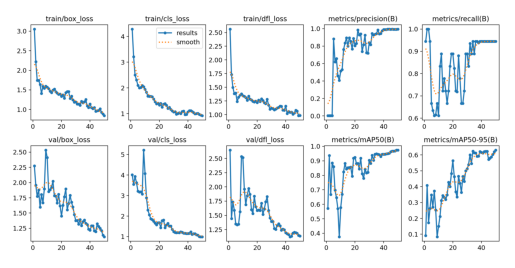

In [ ]:
# Результаты обучения
TRAIN_RESULTS_PICTURE = PATH_DATASET + 'runs/detect/train2/results.png'
plt.imshow(Image.open(TRAIN_RESULTS_PICTURE))
plt.axis('off')
plt.show()


## Запуск модели на тестовой выборке

In [ ]:
PATH_DATASET = '/content/drive/MyDrive/uai/st1/glasses_dataset_yolo8/'
MODEL_PATH = PATH_DATASET + 'runs/detect/train2/weights/best.pt'
TEST_FILES = PATH_DATASET + 'test/'
PATH_PREDICT = PATH_DATASET + 'runs/detect/predict_yolov8n_50epochs/'

# Загрузка модели и получение результатов на тестовой выборке
model = YOLO(MODEL_PATH)
results = model(TEST_FILES, imgsz=640, show_labels=True, max_det=1, save=True, name=PATH_PREDICT)



image 1/4 /content/drive/MyDrive/uai/st1/glasses_dataset_yolo8/test/10.jpg: 640x480 1 arm_tag, 6.9ms
image 2/4 /content/drive/MyDrive/uai/st1/glasses_dataset_yolo8/test/13.jpg: 640x480 1 arm_tag, 16.0ms
image 3/4 /content/drive/MyDrive/uai/st1/glasses_dataset_yolo8/test/22.jpg: 640x480 1 arm_tag, 6.5ms
image 4/4 /content/drive/MyDrive/uai/st1/glasses_dataset_yolo8/test/test.jpg: 640x480 1 arm_tag, 6.6ms
Speed: 3.2ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to /content/drive/MyDrive/uai/st1/glasses_dataset_yolo8/runs/detect/predict_yolov8n_50epochs


## Отрисовка результатов и обрезка на тестовой выборке

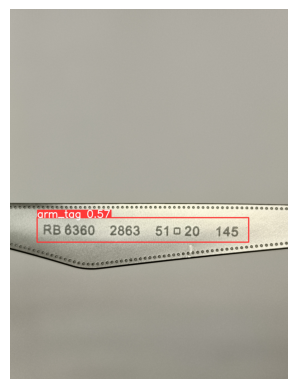

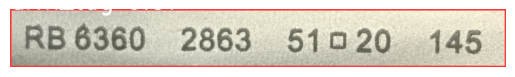

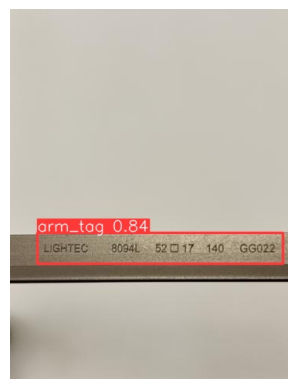

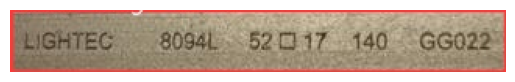

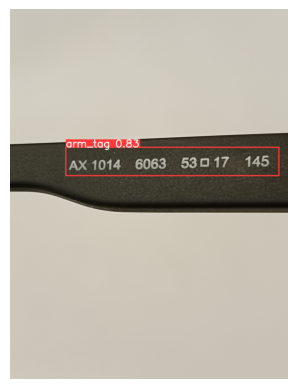

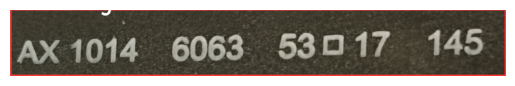

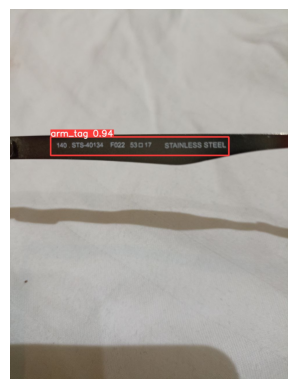

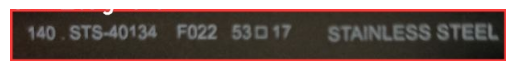

In [ ]:
from pathlib import Path
%matplotlib inline

# Функция для отрисовки  изображения
def display_img(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()


# Отрисовка результатов на полном изображении, обрезка и сохранение обрезанных изображений
predicted_images = glob.glob(PATH_PREDICT + '*.jpg')

img_num = 0
for img in predicted_images:
  img_to_show = Image.open(img)
  display_img(img_to_show)
  x_min, y_min, x_max, y_max = results[img_num].boxes.data[0][:4]
  cropped_img = img_to_show.crop((int(x_min), int(y_min), int(x_max), int(y_max)))
  display_img(cropped_img)
  path = Path(img)
  cropped_name = PATH_PREDICT + 'cropped_' + path.name
  cropped_img.save(cropped_name)
  img_num+= 1

## Чтение текста из рамок и поиск распознанного текста в таблице атрибутов

In [ ]:
# Функция загрузки файла с атрибутами оправ и формированием списка атрибутов
def frames_attr():
  ATTR_FRAMES_FILE = PATH_DATASET + 'Атрибуты_3.xlsx'
  excel_attr = pd.read_excel(ATTR_FRAMES_FILE, names=['Num', 'empty', 'Attr_full','Attr1', 'Attr2', 'Attr3', 'Attr4', 'Attr5'], index_col=0)
  df = pd.DataFrame(excel_attr)
  df = df.dropna(subset=['Attr_full'])
  attr_list = df['Attr_full'].tolist()
  attr_list_cleaned = ["".join(s.split()) for s in attr_list]
  return attr_list_cleaned

# Функция для отрисовки  изображения
def display_img(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

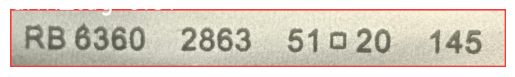

Распознанный текст:  RB6360 2863 51020 145
Текст для поиска в списке атрибутов: RB6360286351020145
В таблице атрибутов под порядковым номером  10  найден текст:  RB6360286351*20145   Индекс сходства 94


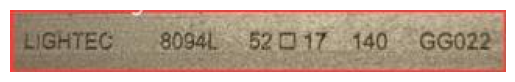

Распознанный текст:  “LGH $094L 52017 140 - GGO22
Текст для поиска в списке атрибутов: “LGH$094L52017140-GGO22
В таблице атрибутов под порядковым номером  13  найден текст:  LIGHTEC8094L52*17140GG022   Индекс сходства 77


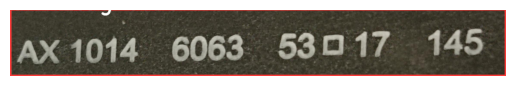

Распознанный текст:  AX 1014 6063 53017 145
Текст для поиска в списке атрибутов: AX1014606353017145
В таблице атрибутов под порядковым номером  22  найден текст:  AX1014606353*17145   Индекс сходства 94


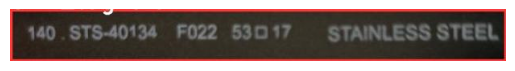

Распознанный текст:  140 .STS-40134 F022 53017 STAINLESS STEEL
Текст для поиска в списке атрибутов: 140.STS-40134F02253017STAINLESSSTEEL
В таблице атрибутов под порядковым номером  67  найден текст:  WE514505250*18140   Индекс сходства 50


In [ ]:
# Распознавание текста и поиск наилучшего совпадения из списка
PATH_PREDICT = PATH_DATASET + 'runs/detect/predict_yolov8n_50epochs/'

attributes_cleaned = frames_attr()

images_for_extraction = glob.glob(PATH_PREDICT + 'cropped*.jpg')

for img in images_for_extraction:
  img_to_show = Image.open(img)
  display_img(img_to_show)
#  print('size=', img_to_show.size)

  if img_to_show.size[0] > 1000:
    img_to_show = img_to_show.resize((600, 68))
  if img_to_show.size[0] < 400:
    img_to_show = img_to_show.resize((400, 42))

  extracted_text = pytesseract.image_to_string(img_to_show).strip()
  print('Распознанный текст: ', extracted_text)

  text_cleaned = "".join(extracted_text.split())
  a = process.extractOne(text_cleaned, attributes_cleaned)  # находит совпадение текста с лучшим индексом сходства в списке атрибутов
  row_num = attributes_cleaned.index(a[0])

  print('Текст для поиска в списке атрибутов:', text_cleaned)
  print('В таблице атрибутов под порядковым номером ', row_num+1, ' найден текст: ',a[0], ' ', 'Индекс сходства', a[1])
  print('='*30)


  # imgcv2 = cv2.imread(img)
  # gray = cv2.cvtColor(imgcv2, cv2.COLOR_BGR2GRAY)
  # display_img(gray)
  # print('size=', gray.size)
  # extracted_text = pytesseract.image_to_string(gray)
  # print(extracted_text)
